This notebook is here to try out the ```universalbands``` package.

1. Start by creating a virtualenv in which to test the package: ub-env-3.11.0
2. Install the ```ipython, numpy, cvxpy, gpy and scikit-learn``` packages.

In [1]:
import universalbands as ub
from universalbands.kernels import Matern
from GPy.kern import Matern52
from GPy.models.gp_regression import GPRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels

def plot(X, y, X_cal, y_cal, X_test, y_test, mean_estimation_test, bands_estimation_test, limits, title, save_path):
    line_width = 5
    marker_size = 120

    # Make the upper bounds and lower bounds from the mean estimation and the prediction bands.
    upper_bound = mean_estimation_test + bands_estimation_test
    lower_bound = mean_estimation_test - bands_estimation_test

    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    X_test_sq = X_test.squeeze()
    mean_est_sq = mean_estimation_test.squeeze()
    sorted_indices = np.argsort(X_test_sq)
    X_test_sorted = X_test_sq[sorted_indices].squeeze()
    mean_est_sorted = mean_est_sq[sorted_indices].squeeze()

    upper_bound_sq = upper_bound.squeeze()
    lower_bound_sq = lower_bound.squeeze()
    upper_bound_sorted = upper_bound_sq[sorted_indices].squeeze()
    lower_bound_sorted = lower_bound_sq[sorted_indices].squeeze()

    ax.plot(X_test_sorted, mean_est_sorted, color = "blue", linewidth = line_width)
    ax.fill_between(X_test_sorted, lower_bound_sorted, upper_bound_sorted, alpha = 0.2, color = "orange")

    ax.scatter(X, y, s = marker_size, c = "blue", alpha = 1, marker = "^")
    ax.scatter(X_cal, y_cal, s = marker_size, c = "orange", alpha = 1, marker = "v")
    ax.scatter(X_test, y_test, s = 35, c = "black", alpha = 0.6, marker = "o")

    ax.plot(X_test_sorted, upper_bound_sorted, color = "orange", linewidth = line_width, ls = "--")
    ax.plot(X_test_sorted, lower_bound_sorted, color = "orange", linewidth = line_width, ls = "--")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim(limits)
    #ax.set_title(label = title, loc = "center")

    plt.tight_layout()
    fig.savefig(save_path, transparent = True, dpi = 600)

In [3]:
kernels.ConstantKernel(constant_value=0.2)

0.447**2

# Trying sequential code.

 /opt/conda/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning:
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    


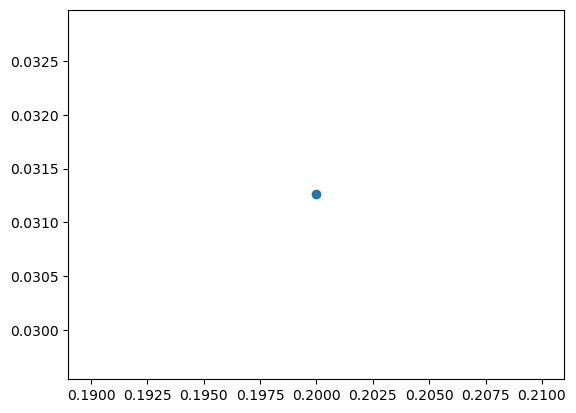

In [3]:
case_number = 5
hsic = []
mi = []
length_scale_list = np.linspace(0.2, 0.2, 1)

X_train, y_train = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 101, sample_dim = 1, seed = 123)
X_cal, y_cal = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 102, sample_dim = 1, seed = 321)
X_test, y_test = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 300, sample_dim = 1, seed = 987)
X_gp, y_gp = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 103, sample_dim = 1, seed = 86)

kernel = Matern52(input_dim = 1)
gp_model = GPRegression(X_gp, y_gp, kernel)
gp_model.optimize_restarts(num_restarts = 10, messages = False, verbose = False, max_iters = 1000)

mean_train_prediction, _ = gp_model.predict(X_train)
mean_cal_prediction, _ = gp_model.predict(X_cal)
mean_test_prediction, _ = gp_model.predict(X_test)

for sdp_length_scale in length_scale_list:
     sdp_model = ub.UniversalBandsRegressor(
          #kernel = kernels.Matern(length_scale = sdp_length_scale, length_scale_bounds = (1e-5, 1e5), nu = 2.5), 
          kernel = Matern(length_scale = sdp_length_scale, sigma = 1, nu = 2.5),
          problem = "Liang",
          checkSDP = False
     )
     sdp_model.train(X = X_train, y = y_train, mean_estimator = mean_train_prediction)
     sdp_model.calibrate(X = X_cal, y = y_cal, mean_estimator = mean_cal_prediction, alpha = 0.05, metric_list = ["mutual_information", "energy_hsic"])
     prediction_bands = sdp_model.predict(X = X_test)

     hsic.append(sdp_model.metrics["energy_hsic"])
     mi.append(sdp_model.metrics["mutual_information"])

plt.scatter(length_scale_list, hsic)

 /opt/conda/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning:
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    


Length scale is:  0.2
Mutual Information is:  0.05300815153730243
Energy HSIC is:  0.031259152214150696


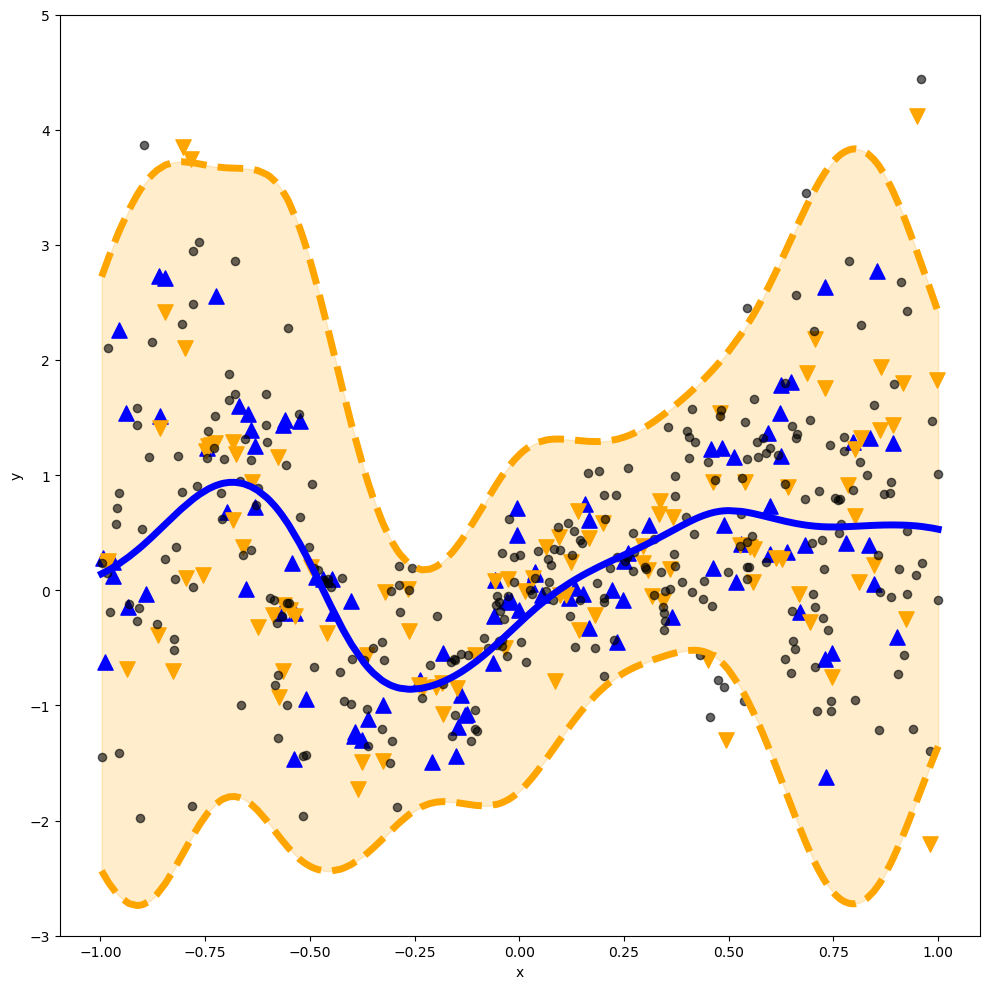

In [4]:
sdp_model = ub.UniversalBandsRegressor(
    #kernel = kernels.Matern(length_scale = length_scale_list[np.argmax(hsic)], length_scale_bounds = (1e-5, 1e5), nu = 2.5), 
    kernel = Matern(length_scale = sdp_length_scale, sigma = 1, nu = 2.5),
    problem = "Liang",
    checkSDP = False
)
sdp_model.train(X = X_train, y = y_train, mean_estimator = mean_train_prediction)
sdp_model.calibrate(X = X_cal, y = y_cal, mean_estimator = mean_cal_prediction, alpha = 0.05, metric_list = ["mutual_information", "energy_hsic"])
prediction_bands = sdp_model.predict(X = X_test)

print("Length scale is: ", length_scale_list[np.argmax(hsic)])
print("Mutual Information is: ", sdp_model.metrics["mutual_information"])
print("Energy HSIC is: ", sdp_model.metrics["energy_hsic"])

plot(X = X_train, y = y_train, X_cal = X_cal, y_cal = y_cal, X_test = X_test, y_test = y_test, mean_estimation_test = mean_test_prediction, bands_estimation_test = prediction_bands,
     limits = (-3, 5), title = "This is my title.", save_path = "figure_01.pdf")

# Trying simultaneous code

### Train a GP.

Multiple otpions:
1. Train it on a different data set.
2. Train it on the same datatset as the optimisation dataset used for the SDP algorithm.

Then retrieve the posterior kernel.
It has multiple hyperparamaters:
- lengthscale
- variance
- nugget

What should the kernel used to compute the alphas be?
- same lengthscale
- same lengthscale and same variance
- same lengthscale and same nugget
- posterior kernel (same lengthscale, variance and nugget)

In [31]:
case_number = 5

X_gp, y_gp = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 100, sample_dim = 1, seed = 123)

### Different training set

Optimization restart 1/3, f = 126.65147934263209
Optimization restart 2/3, f = 126.6514793425433
Optimization restart 3/3, f = 126.65147934254611
Posterior hyperparameters: 
     {'lengthscale': 0.26441555841650927, 'variance': 1.0, 'nugget': 0.5864957198113625}


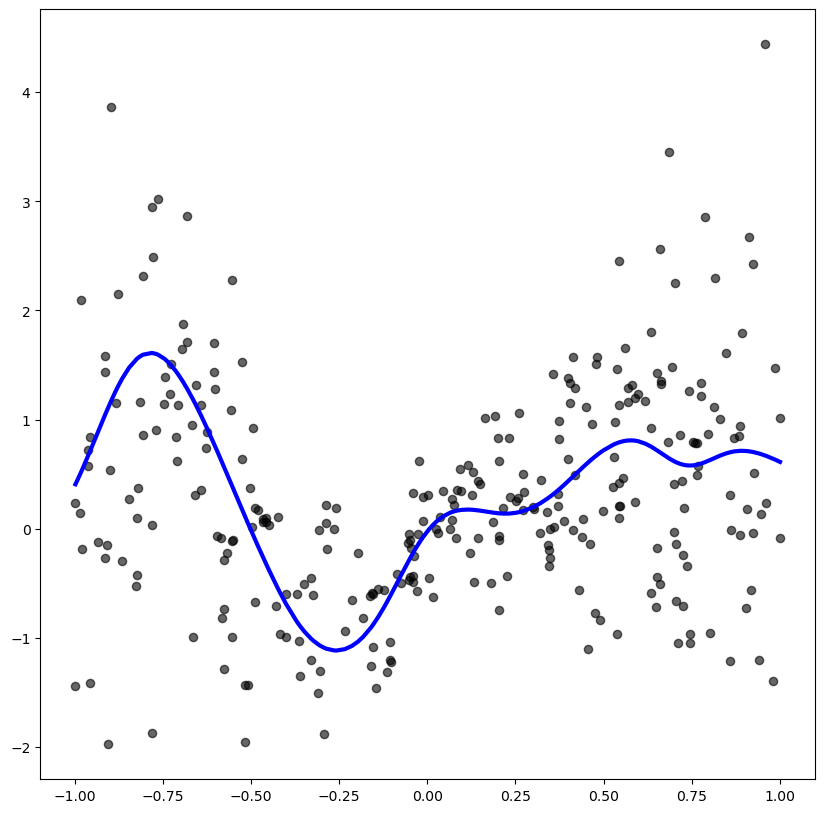

In [ ]:
# Define kernel and GP model
kernel = Matern52(input_dim=1)
gp_model = GPRegression(X_gp, y_gp, kernel)
gp_model.kern.variance.fix()
# Optimize the GP hyperparameters
gp_model.optimize_restarts(num_restarts=3, messages=False, verbose=True, max_iters=1000)
gp_predictions, _ = gp_model.predict()

## Train the GP
from GPy.kern import Matern52
from GPy.models import GPRegression
import numpy as np



fig, ax = plt.subplots(1, 1, figsize=(10,10))
X_test_sq = X_test.squeeze()
sorted_indices = np.argsort(X_test_sq)
X_test_sorted = X_test_sq[sorted_indices].squeeze()
gp_predictions_sq = gp_predictions[sorted_indices].squeeze()
ax.scatter(X_test, y_test, s = 35, c = "black", alpha = 0.6, marker = "o")
ax.plot(X_test_sorted, gp_predictions_sq, color = "blue", linewidth = 3)
fig.show()

# Extract posterior hyperparameters
posterior_lengthscale = gp_model.kern.lengthscale[0]
posterior_variance = gp_model.kern.variance[0]
posterior_nugget = gp_model.Gaussian_noise.variance[0]
print("Posterior hyperparameters: \n    ", {"lengthscale": posterior_lengthscale, "variance": posterior_variance, "nugget": posterior_nugget})

In [37]:
# From GPy
gamma = gp_model.posterior.woodbury_vector
K = gp_model.kern.K(X_gp)
post_training_norm = (gamma.T @ K @ gamma).item()
print(post_training_norm)

7.909219199557189


In [38]:
# Manually
matern_and_nugget = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5) + kernels.WhiteKernel(noise_level=posterior_nugget)
matern_and_nugget_matrix = matern_and_nugget(X=X_gp)
gamma_2 = np.linalg.solve(matern_and_nugget_matrix, y_gp)

only_matern = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5) 
only_matern_matrix = only_matern(X=X_gp)
manual_norm = (gamma_2.T @ only_matern_matrix @ gamma_2).item()
print(manual_norm)

7.909219271885393


Posterior hyperparameters: 
     {'lengthscale': 0.2644155470693088, 'variance': 1.0, 'nugget': 0.586495722522769}
  Mat52.       |               value  |  constraints  |  priors
  variance     |                 1.0  |   +ve fixed   |        
  lengthscale  |  0.2644155470693088  |      +ve      |        
False
Same lengthscale norm: 4790.167368278555
Same lengthscale and nugget norm: 520.9412746497978
Same lengthscale and variance norm: 1228590258066.4702
Same posterior norm: 98.49480878162468
Computed from GPy: 7.909219127878855
[[98.49480569]]
9.453741796071332


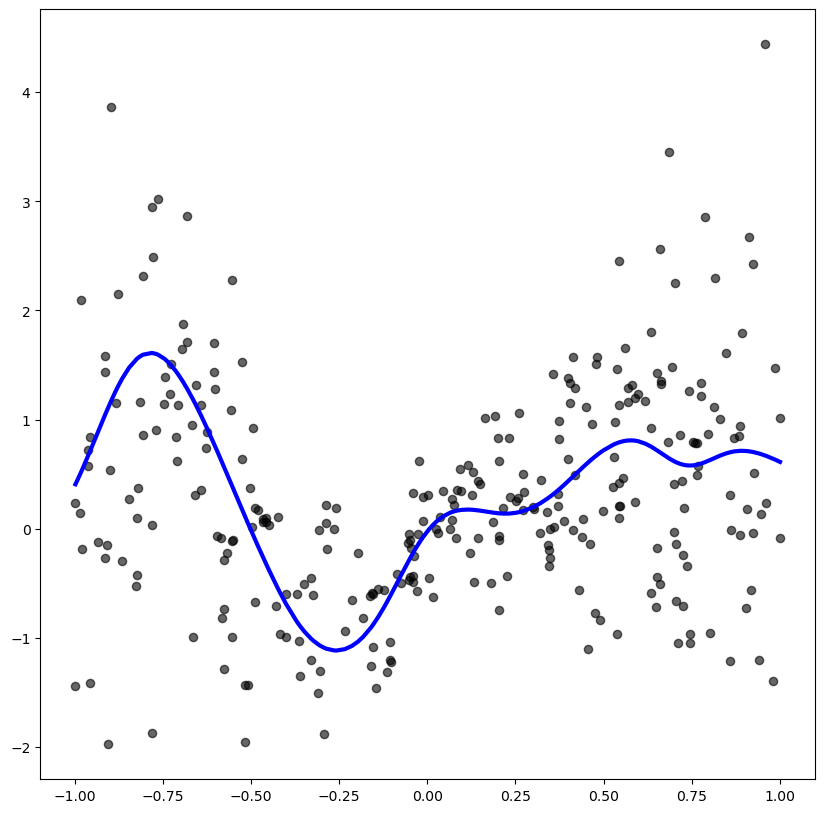

In [ ]:


## Compute the different norms for different kernels.



same_lengthscale_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5)

# Same lengthscale kernel
same_lengthscale_gram_matrix = same_lengthscale_kernel(X = X_gp)+1e-2*np.eye(X_gp.shape[0])
same_lengthscale_alpha = np.linalg.solve(same_lengthscale_gram_matrix, y_gp)
same_lengthscale_norm = (same_lengthscale_alpha.T @ same_lengthscale_gram_matrix @ same_lengthscale_alpha).item()

# Same lengthscale and nugget kernel
same_lengthscale_nugget_gram_matrix = same_lengthscale_kernel(X = X_gp) + 1e-1*np.eye(X_gp.shape[0])
same_lengthscale_nugget_alpha = np.linalg.solve(same_lengthscale_nugget_gram_matrix, y_gp)
same_lengthscale_nugget_norm = (same_lengthscale_nugget_alpha.T @ same_lengthscale_nugget_gram_matrix @ same_lengthscale_nugget_alpha).item()

same_lengthscale_variance_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5) * kernels.ConstantKernel(constant_value = posterior_variance)

# Same lengthscale and variance kernel
same_lengthscale_variance_gram_matrix = same_lengthscale_variance_kernel(X = X_gp) 
same_lengthscale_variance_alpha = np.linalg.solve(same_lengthscale_variance_gram_matrix, y_gp)
same_lengthscale_variance_norm = (same_lengthscale_variance_alpha.T @ same_lengthscale_variance_gram_matrix @ same_lengthscale_variance_alpha).item()

# Same posterior kernel
same_posterior_gram_matrix = same_lengthscale_variance_kernel(X = X_gp) + posterior_nugget*np.eye(X_gp.shape[0])
same_posterior_alpha = np.linalg.solve(same_posterior_gram_matrix, y_gp)
same_posterior_norm = (same_posterior_alpha.T @ same_posterior_gram_matrix @ same_posterior_alpha).item()

# Fro GPy
gamma = gp_model.posterior.woodbury_vector
K = gp_model.kern.K(X_gp)
print(gp_model.kern)
post_training_norm = (gamma.T @ K @ gamma).item()
print(np.allclose(gamma, same_lengthscale_alpha))

# Print results
print("Same lengthscale norm:", same_lengthscale_norm)
print("Same lengthscale and nugget norm:", same_lengthscale_nugget_norm)
print("Same lengthscale and variance norm:", same_lengthscale_variance_norm)
print("Same posterior norm:", same_posterior_norm)
print("Computed from GPy:", post_training_norm)
gamma = gp_model.posterior.woodbury_vector
K = gp_model.kern.K(X_gp) + gp_model.Gaussian_noise.variance * np.eye(X_gp.shape[0])
norm = np.dot(gamma.T, np.dot(K, gamma))
print(norm)

same_posterior_gram_matrix = same_lengthscale_variance_kernel(X = X_gp) + posterior_nugget*np.eye(X_gp.shape[0])
same_posterior_alpha = np.linalg.solve(same_posterior_gram_matrix, y_gp)
same_lengthscale_gram_matrix = same_lengthscale_kernel(X = X_gp)+1e-2*np.eye(X_gp.shape[0])

test = (same_posterior_alpha.T @ same_lengthscale_gram_matrix @ same_posterior_alpha).item()
print(test)

In [16]:
print("Condition number (same lengthscale):", np.linalg.cond(same_lengthscale_gram_matrix))
print("Condition number (same lengthscale and nugget):", np.linalg.cond(same_lengthscale_nugget_gram_matrix))


Condition number (same lengthscale): 1655246976204.9912
Condition number (same lengthscale and nugget): 48.58087187015731


### Same training set as SDP optimisation.

Posterior hyperparameters: 
     {'lengthscale': 0.23229588143323793, 'variance': 0.6813970787878105, 'nugget': 0.581982883728484}
Same lengthscale norm: 642742624727.5093
Same lengthscale and nugget norm: 97.70069680783935
Same lengthscale and variance norm: 940621637260.9868
Same posterior norm: 101.00000094312041


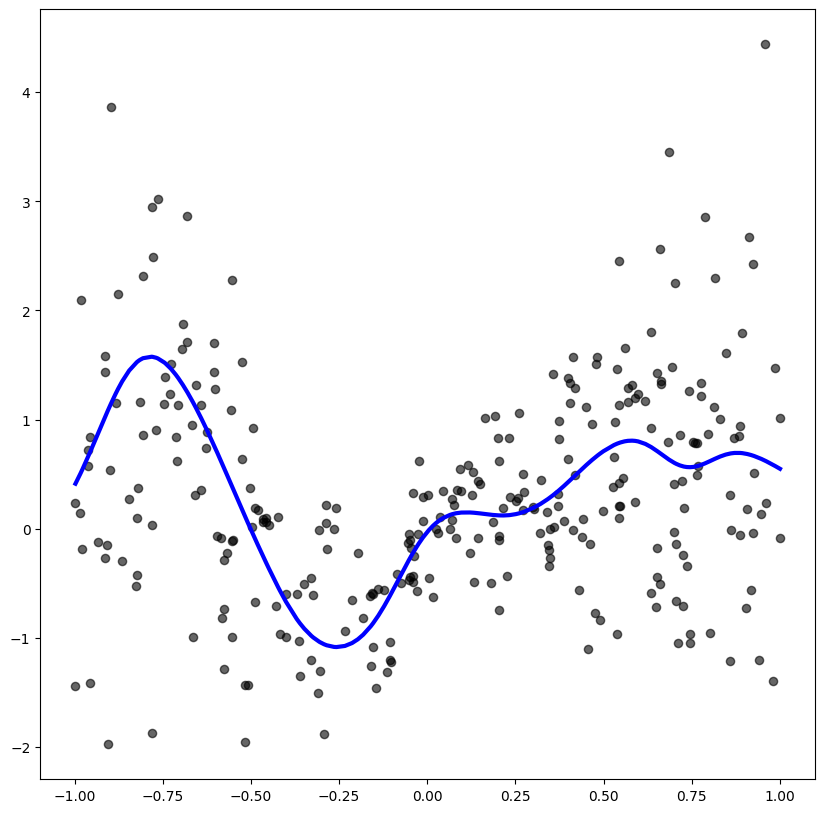

In [16]:
## Train the GP
from GPy.kern import Matern52
from GPy.models import GPRegression
import numpy as np

# Define kernel and GP model
kernel = Matern52(input_dim=1)
gp_model = GPRegression(X_train, y_train, kernel)

# Optimize the GP hyperparameters
gp_model.optimize_restarts(num_restarts=10, messages=False, verbose=False, max_iters=1000)
gp_predictions, _ = gp_model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
X_test_sq = X_test.squeeze()
sorted_indices = np.argsort(X_test_sq)
X_test_sorted = X_test_sq[sorted_indices].squeeze()
gp_predictions_sq = gp_predictions[sorted_indices].squeeze()
ax.scatter(X_test, y_test, s = 35, c = "black", alpha = 0.6, marker = "o")
ax.plot(X_test_sorted, gp_predictions_sq, color = "blue", linewidth = 3)
fig.show()


## Compute the different norms for different kernels.

# Extract posterior hyperparameters
posterior_lengthscale = gp_model.kern.lengthscale[0]
posterior_variance = gp_model.kern.variance[0]
posterior_nugget = gp_model.Gaussian_noise.variance[0]
print("Posterior hyperparameters: \n    ", {"lengthscale": posterior_lengthscale, "variance": posterior_variance, "nugget": posterior_nugget})

same_lengthscale_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5)

# Same lengthscale kernel
same_lengthscale_gram_matrix = same_lengthscale_kernel(X = X_train)
same_lengthscale_alpha = np.linalg.solve(same_lengthscale_gram_matrix, y_train)
same_lengthscale_norm = (same_lengthscale_alpha.T @ same_lengthscale_gram_matrix @ same_lengthscale_alpha).item()

# Same lengthscale and nugget kernel
same_lengthscale_nugget_gram_matrix = same_lengthscale_kernel(X = X_train) + posterior_nugget*np.eye(X_train.shape[0])
same_lengthscale_nugget_alpha = np.linalg.solve(same_lengthscale_nugget_gram_matrix, y_train)
same_lengthscale_nugget_norm = (same_lengthscale_nugget_alpha.T @ same_lengthscale_nugget_gram_matrix @ same_lengthscale_nugget_alpha).item()

same_lengthscale_variance_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5) * kernels.ConstantKernel(constant_value = posterior_variance)

# Same lengthscale and variance kernel
same_lengthscale_variance_gram_matrix = same_lengthscale_variance_kernel(X = X_train) 
same_lengthscale_variance_alpha = np.linalg.solve(same_lengthscale_variance_gram_matrix, y_train)
same_lengthscale_variance_norm = (same_lengthscale_variance_alpha.T @ same_lengthscale_variance_gram_matrix @ same_lengthscale_variance_alpha).item()

# Same posterior kernel
same_posterior_gram_matrix = same_lengthscale_variance_kernel(X = X_train) + posterior_nugget*np.eye(X_train.shape[0])
same_posterior_alpha = np.linalg.solve(same_posterior_gram_matrix, y_train)
same_posterior_norm = (same_posterior_alpha.T @ same_posterior_gram_matrix @ same_posterior_alpha).item()


# Print results
print("Same lengthscale norm:", same_lengthscale_norm)
print("Same lengthscale and nugget norm:", same_lengthscale_nugget_norm)
print("Same lengthscale and variance norm:", same_lengthscale_variance_norm)
print("Same posterior norm:", same_posterior_norm)

## Trying the full simultaneous code

0.23229586364014257
0.581982830246425
0.6813968842122149
s value from GP:  97.70070418694281
----------
Length scale for this model is 0.2.


 /opt/conda/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning:
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    


HSIC for this model is 0.0204797337855336.


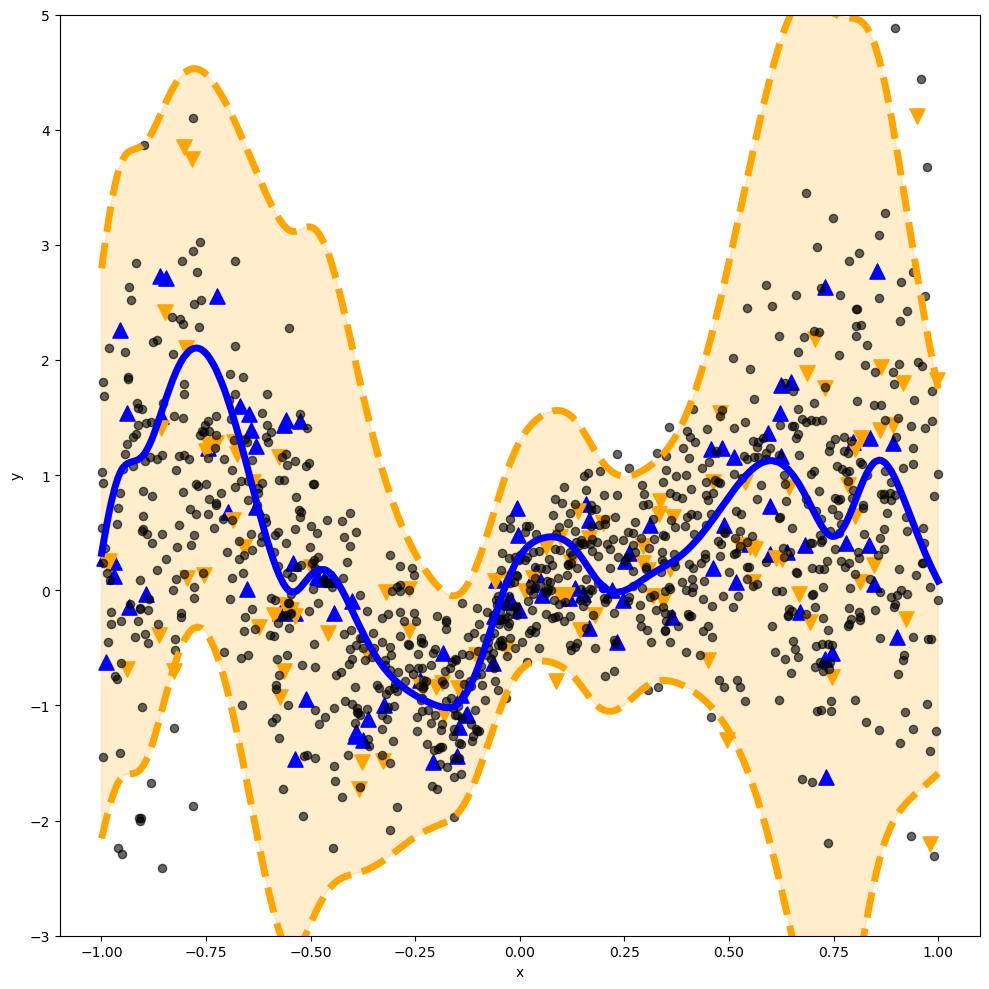

In [7]:
case_number = 5
sample_size = 100
sample_dim = 1
hsic = []
mi = []
solver_min = []

length_scale_list = np.linspace(0.2, 0.2, 1)

X_train, y_train = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = sample_size + 1, sample_dim = sample_dim, seed = 123)
X_cal, y_cal = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = sample_size + 2, sample_dim = sample_dim, seed = 321)
X_test, y_test = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 10*sample_size + 3, sample_dim = sample_dim, seed = 987)
X_gp, y_gp = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = sample_size + 4, sample_dim = sample_dim, seed = 86)

kernel = Matern52(input_dim = 1)
gp_model = GPRegression(X_train, y_train, kernel)
gp_model.optimize_restarts(num_restarts = 10, messages = False, verbose = False, max_iters = 1000)

posterior_lengthscale = gp_model.kern.lengthscale[0]
posterior_variance = gp_model.kern.variance[0]
posterior_nugget = gp_model.Gaussian_noise.variance[0]

print(posterior_lengthscale)
print(posterior_nugget)
print(posterior_variance)

#same_lengthscale_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5) + kernels.WhiteKernel(noise_level=posterior_nugget, noise_level_bounds="fixed")
same_lengthscale_kernel = Matern(length_scale = posterior_lengthscale, sigma = 1, nu = 2.5, nugget = posterior_nugget)
same_lengthscale_nugget_gram_matrix = same_lengthscale_kernel(X = X_train)
same_lengthscale_nugget_alpha = np.linalg.solve(same_lengthscale_nugget_gram_matrix, y_train)
same_lengthscale_nugget_norm = (same_lengthscale_nugget_alpha.T @ same_lengthscale_nugget_gram_matrix @ same_lengthscale_nugget_alpha).item()

print("s value from GP: ", same_lengthscale_nugget_norm)

for variance_lengthscale in length_scale_list:
    print("----------")
    print(f"Length scale for this model is {variance_lengthscale}.")
    sdp_model = ub.UniversalFunctionAndBandsRegressor(
        #mean_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5),
        #variance_kernel = kernels.Matern(length_scale = variance_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5), 
        mean_kernel = Matern(length_scale = posterior_lengthscale, sigma = 1, nu = 2.5, nugget = 0),
        variance_kernel = Matern(length_scale = variance_lengthscale, sigma = 1, nu = 2.5, nugget = 0),
        lambda2 = 1,
        delta = 1e-3,
        s = 101.00003346865246,
        problem = "Liang",
        checkSDP = False,
        verbose = False
    )
    sdp_model.train(X = X_train, y = y_train)
    sdp_model.calibrate(X = X_cal, y = y_cal, alpha = 0.05, metric_list = ["mutual_information", "energy_hsic"])
    mean_test_prediction, prediction_bands = sdp_model.predict(X = X_test)

    crruent_hsci = sdp_model.metrics["energy_hsic"]
    hsic.append(sdp_model.metrics["energy_hsic"])
    solver_min.append(sdp_model.solver_min)
    mi.append(sdp_model.metrics["mutual_information"])
    print(f"HSIC for this model is {crruent_hsci}.")

    plot(X = X_train, y = y_train, X_cal = X_cal, y_cal = y_cal, X_test = X_test, y_test = y_test, mean_estimation_test = mean_test_prediction, bands_estimation_test = prediction_bands, limits = (-3, 5), title = "This is my title.", save_path = "figure_01.pdf")

plt.scatter(length_scale_list, hsic, color = "blue")

# Other